# Progetto di Machine Learning
#### Double inverted pendulum - Lorenzo Frangella 1899674

In [1]:
# Code to run in only in colab for packet download
!pip3 install gymnasium
!pip3 install gym[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 14.4 MB/s eta 0:00:00


In [13]:
import gymnasium as gym
import math
import os
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Hyperparameters used in our neural network

In [14]:
DISCOUNT = 0.95
LEARNING_RATE = 1e-4


A sample of the environment

In [51]:
# test of the environment

env = gym.make('InvertedDoublePendulum-v4',render_mode="none") #change w "human" if needed
observation, info = env.reset()

for i in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()


OBSERVATIONS = env.observation_space.shape[0]
ACTIONS = 64



In [16]:

def draw_result(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    plt.plot(lst_iter, lst_acc, '-r', label='accuracy')

    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

In [17]:
def draw_only_reward(lst_iter, lst_acc,title):
  plt.plot(lst_iter, lst_acc, '-r', label='accuracy')

  plt.xlabel("n iteration")
  plt.legend(loc='upper left')
  plt.title(title)

  # save image
  plt.savefig(title+".png")  # should before show method

  # show
  plt.show()

### Convert the output of the neural network to the interval -1,1
Since as action we have only one scalar value that represent magnitude and direction of the force applied to the cart, we have to "cast" the output of the neural network into a scalar contiguos value

In [19]:
def discrete_to_continue_action(index):
    value = (2/ACTIONS) * index - 1
    return value

Defining the structure of the neural network needed for DQN algorithm

In [37]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

print(OBSERVATIONS)
print(ACTIONS)

main_nn = DQN(OBSERVATIONS,ACTIONS).to(device)
target_nn = DQN(OBSERVATIONS,ACTIONS).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

11
128


In [53]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128,128)
        self.layer5 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer3(x)

print(OBSERVATIONS)
print(ACTIONS)

main_nn = DQN(OBSERVATIONS,ACTIONS).to(device)
target_nn = DQN(OBSERVATIONS,ACTIONS).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

11
64


Defining the data structure that is needed for the training

In [9]:
class ReplayMemory(object):

    def __init__(self, size, device ="cpu"):
        self.buffer = deque(maxlen=size)
        self.device = device

    def add(self,state,action, reward, next_state, done):
        self.buffer.append((state, action,reward,next_state,done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, num_samples):
        states, actions, rewards, next_states, dones = [] , [] , [] , [] , []
        idx = np.random.choice(len(self.buffer), num_samples)
        for i in idx:
            elem = self.buffer[i]
            state, action, reward, next_state, done = elem
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.float32)
        return states, actions, rewards, next_states, dones



#### The following part of code is needed to develop a epsilon-greedy policy

With a given probability epsilon a random action is choosen otherwise is choosen the best action


In [21]:
def select_epsilon_greedy_action(state, epsilon):
    result = np.random.uniform()
    if result < epsilon:
        return env.action_space.sample()
    else:
        qs = main_nn(state).cpu().data.numpy()
        action_decimal = np.array([(np.argmax(qs)*(2/ACTIONS))-1])
        return action_decimal

#### Definition of a train step that is performed on the replay memory of size batch

In [22]:
def training_step(states, actions, rewards, next_states, dones):
    max_next_qs = target_nn(next_states).max(-1).values
    target = rewards + (1.0 - dones) * DISCOUNT * max_next_qs
    qs = main_nn(states)
    action_masks = F.one_hot(actions.type(torch.int64), ACTIONS)
    masked_qs = (action_masks * qs).sum(dim=-1)
    loss = loss_fn(masked_qs, target.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [57]:
losses = [0]
accuracy = [0]
episodes = [0]



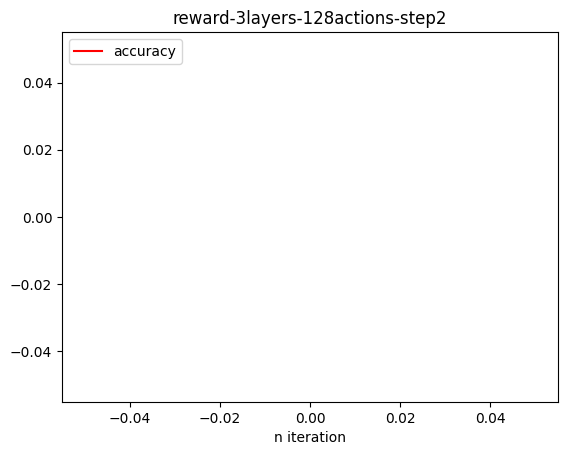

In [58]:
draw_only_reward(episodes,accuracy,"reward-3layers-128actions-step2")

In [59]:
# Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayMemory(100000, device=device)
cur_frame = 0
loss = 0

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
for episode in range(1,num_episodes+1):
  state = env.reset()[0].astype(np.float32)
  ep_reward, done = 0, False
  while not done:
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, 0)
    next_state, reward, done, info, unknown_attribute = env.step(action)
    next_state = next_state.astype(np.float32)
    ep_reward += reward
    # Save to experience replay.
    integer_action = (action + 1)*(ACTIONS/2)
    #print(f"the actions is {action} and its integer {integer_action} multiplied by {ACTIONS}")
    buffer.add(state, integer_action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())

    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      next_states = torch.from_numpy(next_states).to(device)
      rewards = torch.from_numpy(rewards).to(device)
      states = torch.from_numpy(states).to(device)
      dones = torch.from_numpy(dones).to(device)
      actions = torch.from_numpy(actions).to(device)


      loss = 0 #training_step(states, actions, rewards, next_states, dones)

  if episode < 950:
    epsilon -= 0.001

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  if episode % 50 == 0:
    losses.append(loss)
    accuracy.append(np.mean(last_100_ep_rewards))
    episodes.append(episodes[-1]+50)
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}, loss: {loss}')

draw_result(episodes,losses,accuracy,"train-5layers-64actions")
env.close()

Episode 50/1000. Epsilon: 0.950. Reward in last 100 episodes: 17135.03, loss: 0
Episode 100/1000. Epsilon: 0.900. Reward in last 100 episodes: 16361.15, loss: 0
Episode 150/1000. Epsilon: 0.850. Reward in last 100 episodes: 17706.76, loss: 0
Episode 200/1000. Epsilon: 0.800. Reward in last 100 episodes: 16966.78, loss: 0


In [ ]:

env_test = gym.make('InvertedDoublePendulum-v4',render_mode="human")

observation = env_test.reset()[0].astype(np.float32)


for i in range(1000):
    inp = torch.from_numpy(observation)
    action = select_epsilon_greedy_action(inp,0)
    observation, reward, terminated, truncated, info = env_test.step(action)
    observation = observation.astype(np.float32)



    if terminated or truncated:
        observation, info = env.reset()
        observation = observation.astype(np.float32)


env_test.close

code to export the trained model

In [23]:
PATH = r"./trained_models/"
torch.save(main_nn.state_dict(), PATH + r"trained.pth")

code to import a pretrained model

In [54]:
PATH = r"./trained_models/"
main_nn.load_state_dict(torch.load(PATH + r"trained5l2step64.pth",map_location=device))
#target_nn.load_state_dict(torch.load(PATH + r"trained.pth",map_location=device))

<All keys matched successfully>